## Tensorflow-model

In [508]:
# Import packages for tensorflow
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn import metrics
from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc

from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, LSTM, LeakyReLU, BatchNormalization, Conv1D, MaxPooling1D, Activation
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import ModelCheckpoint

In [509]:
plt.style.use('fivethirtyeight')

In [510]:
var_set = pd.read_csv('var_set.csv', parse_dates=[0],index_col=[0])

In [511]:
var_set['month'] = pd.DatetimeIndex(var_set.index).month

In [512]:
var_set

,SalmonPrice,CodPrice,HalibutPrice,CPI,TWI,month
2013-04-07,39.63,10.754267,47.577612,95.55,92.1500,4
2013-04-14,41.89,10.800751,47.924958,95.70,92.1920,4
2013-04-21,43.07,10.774089,47.092639,95.85,92.7980,4
2013-04-28,42.70,10.569605,47.193296,96.00,93.8080,4
2013-05-05,41.81,10.605343,48.987917,96.02,93.3125,5
...,...,...,...,...,...,...
2022-11-20,82.49,39.417280,76.897925,128.50,122.2180,11
2022-11-27,79.03,39.071706,73.642666,128.40,122.0320,11
2022-12-04,78.05,42.701713,73.193629,128.70,120.8780,12
2022-12-11,75.83,43.652968,74.156841,129.00,122.7060,12


In [513]:
X = var_set.drop(columns=["SalmonPrice"], axis = 1)
y = var_set["SalmonPrice"]

In [514]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 50, shuffle=False)

In [515]:
x_uni = var_set["SalmonPrice"]

In [516]:
x_uni_train,y_uni_test = train_test_split(x_uni, test_size = 50, shuffle=False)

In [517]:
len(X_train)
y_train.shape

(457,)

In [518]:
# # Make predictions
# test_predictions = []

# first_eval_batch = x_minmax_train[-52:]
# current_batch = first_eval_batch.reshape((1, 52, 1))

# for i in range(len(y_minmax_test)):
#     current_pred = model.predict(current_batch)[0]
#     test_predictions.append(current_pred)
#     current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

# true_predictions = scaler.inverse_transform(test_predictions)

# # Plot the predictions
# test_predictions = pd.Series(true_predictions.reshape(50,))
# y_uni_test = pd.Series(y_uni_test.reshape(50,))
# plt.plot(y_uni_test, label='Test Data')
# plt.plot(test_predictions, label='Predictions')
# plt.legend()

# # Evaluate the model
# from sklearn.metrics import mean_squared_error
# from math import sqrt

# rmse = sqrt(mean_squared_error(y_uni_test, test_predictions))
# print('Test RMSE: %.3f' % rmse)

In [519]:
# Scale x and y multivariate
scaler_x = MinMaxScaler()
X_train = scaler_x.fit_transform(X_train)
X_test = scaler_x.transform(X_test)

# Scale y
scaler_y = MinMaxScaler()
y_train = scaler_y.fit_transform(y_train.values.reshape(-1,1))
y_test = scaler_y.transform(y_test.values.reshape(-1,1))

In [520]:
X_train.shape

(457, 5)

In [521]:
y_train.shape

(457, 1)

In [542]:
from tensorflow.keras.optimizers.legacy import Adam
batch_size = [1, 2, 13, 26, 52, 104] #i

epochs = [10, 40, 100]
#epochs = [1, 2, 3]

rmse_list = []

n_input = [1, 4, 52] #n
#n_input = [24, 52] #n

run = 0
b = 0
e = 0

m1 = 0
m2 = 0

uni_multi = [X_train, y_train]

optimuzer = ['adam', 'nadam']

rmse_df = pd.DataFrame(columns=['Run', 'Batch Size', 'Epochs'])

for opt in optimuzer:
    for i in batch_size:
        for n in n_input:
            b = b + 1
            for j in epochs:
                for m1 in range(1):
                    for vari in uni_multi:
                        e = e + 1
                        print('Batch size: '+str(i))
                        print('Lookback -- input: '+str(n))
                        if run % 2 == 0:
                            uni_name = 'Univariate'
                        else:
                            uni_name = 'Multivariate'
                        run = run + 1
                        generated_batches = TimeseriesGenerator(vari, y_train, length=n, batch_size=1)
                        model_name_string = 'Model'+ ' ' + str(run)
                        model_name = 'model_name' + str(run)
                        model_name_test = 'model_name' + str(run)
                        print(model_name)
                        model_name = Sequential()
                        model_name.add(Flatten(input_shape=(n,1)))
                        #model_name.add(Dense(1024, activation='relu', name="hidden_layer_1"))
                        if m1 == 1:
                            model_name.add(Dense(128, activation='relu'))
                            model_name.add(Dropout(0.2))
                            model_name.add(Dense(64, activation='relu'))
                            model_name.add(Dropout(0.2))
                        #m1 = m1 + 1
                        model_name.add(Dense(32, activation='relu'))
                        model_name.add(Dense(1))
                        model_name.compile(optimizer=opt, loss='mse')
                        history = 'history'+str(run)
                        history = model_name.fit(generated_batches,epochs=j,verbose=0, batch_size=i)
                        #print(model_name.summary())
                        model_name_test = model_name
                        test_predictions = []
                        first_eval_batch = y_train[-n:]
                        current_batch = first_eval_batch.reshape((1, n, 1))
                        print(current_batch)
                        for k in range(len(y_test)):
                            current_pred = model_name.predict(current_batch)[0]
                            test_predictions.append(current_pred)
                            current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)
                        true_predictions = scaler_y.inverse_transform(test_predictions)
                        print(test_predictions)
                        rmse = sqrt(mean_squared_error(y_test, true_predictions))
                        rmse_df = rmse_df.append({'Model Name' : model_name_string, 'Run': run, 'Model alternative':m1, 'Batch Size': i, 'Epochs': j, 'Optimizer' : opt, 'Time steps':n, 'Uni/Multi' :uni_name, 'RMSE': rmse}, ignore_index=True)
                        rmse_list.append(rmse)
                        print('Test RMSE: %.3f' % rmse)
                        y_test_inverse = scaler_y.inverse_transform(y_test)
                        plot_predictions = pd.Series(true_predictions.reshape(50,))
                        y_test_inverse = pd.Series(y_test_inverse.reshape(50,))
                        plt.figure(figsize=(10, 6))
                        plt.plot(history.history['loss'], label='Loss(MSE)')
                        plt.legend()
                        plt.savefig('Figures/Neural networks/ForLoop_Tensor/plotLoss_'+str(run)+'.png')

                        plt.figure(figsize=(18,10))
                        plt.plot(y_test_inverse, label='Actual Data')
                        plt.plot(plot_predictions, label='Predictions')
                        plt.legend()
                        plt.savefig('Figures/Neural networks/ForLoop_Tensor/plotModel_'+str(run)+'.png')

Batch size: 2
Lookback -- input: 4
model_name1


2023-04-25 15:03:56.404851: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


KeyboardInterrupt: 

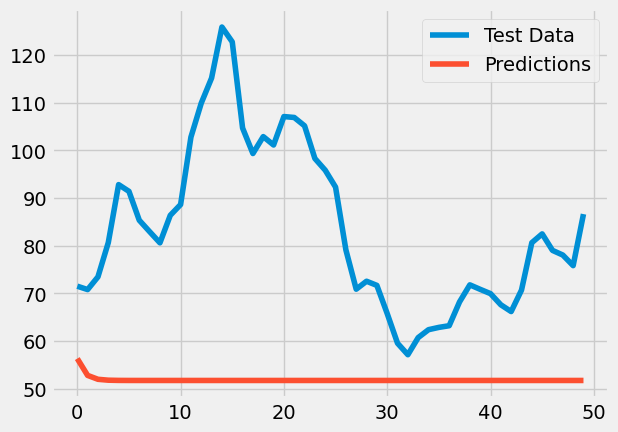

In [ ]:
# y_test = scaler_y.inverse_transform(y_test)
# plot_predictions = pd.Series(true_predictions.reshape(50,))
# y_test = pd.Series(y_test.reshape(50,))
# plt.plot(y_test, label='Test Data')
# plt.plot(plot_predictions, label='Predictions')
# plt.legend()

In [ ]:
rmse_list

[52.16114013062727,
 67.95065966108504,
 53.04385848260451,
 53.68671702282429,
 53.384177744224495,
 54.453016234494164]

In [ ]:
rmse_df['Epochs'] = rmse_df['Epochs'].astype(int)
rmse_df['Batch Size'] = rmse_df['Batch Size'].astype(int)
rmse_df['Run'] = rmse_df['Run'].astype(int)
rmse_df['Model alternative'] = rmse_df['Model alternative'].astype(int)
rmse_df['Time steps'] = rmse_df['Time steps'].astype(int)

In [ ]:
rmse_df.insert(8, 'RMSE', rmse_df.pop('RMSE'))

In [ ]:
rmse_df

,Run,Batch Size,Epochs,Model Name,Model alternative,Optimizer,Time steps,Uni/Multi,RMSE
0,1,1,10,Model 1,0,adam,1,Univariate,52.161140
1,2,1,10,Model 2,0,adam,1,Multivariate,67.950660
2,3,1,40,Model 3,0,adam,1,Univariate,53.043858
3,4,1,40,Model 4,0,adam,1,Multivariate,53.686717
4,5,1,100,Model 5,0,adam,1,Univariate,53.384178
5,6,1,100,Model 6,0,adam,1,Multivariate,54.453016


In [ ]:
pred_list = []

batch = X_train[-n_input:].reshape((1, n_input, 1))

for i in range(n_input):   
    pred_list.append(model_name.predict(batch)[0]) 
    batch = np.append(batch[:,1:,:],[[pred_list[i]]],axis=1)

1/1 [==============================] - 0s 13ms/step


2023-04-25 11:34:56.961056: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 12ms/step


In [ ]:
pred_list = scaler_x.inverse_transform(pred_list)

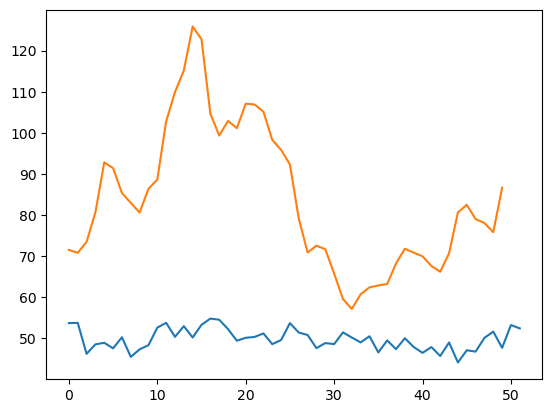

In [ ]:
plt.plot(pred_list, label='Predictions')
plt.plot(scaler_x.inverse_transform(X_test), label='True Data')

In [ ]:
# from pandas.tseries.offsets import DateOffset
# df = pd.DataFrame()
# add_dates = [df.index[-1] + DateOffset(months=x) for x in range(0,13) ]
# future_dates = pd.DataFrame(index=add_dates[1:],columns=df.columns)

IndexError: index -1 is out of bounds for axis 0 with size 0

In [ ]:
rmse_df.sort_values(by=['RMSE'], ascending=True)

,Run,Batch Size,Epochs,Model Name,Model alternative,Optimizer,RMSE
0,1,1,1,Model 1,1,adam,0.446326
2,3,1,3,Model 3,1,adam,0.571496
4,5,2,2,Model 5,1,adam,0.617114
5,6,2,3,Model 6,1,adam,0.646437
1,2,1,2,Model 2,1,adam,0.683482
3,4,2,1,Model 4,1,adam,0.787121


In [ ]:
# Plot model_name1 predictions against actual values
model_name1

In [ ]:
# Create dataframe with RMSE values when length of values does not match length of index
# rmse_df = pd.DataFrame(rmse_list, columns = ['RMSE'])


In [ ]:
# rmse_df

,Run,Batch Size,Epochs,RMSE,Optimizer,Model alternative
0,1,1,1,1.010291,adam,1
1,2,1,2,0.436630,adam,1
2,3,1,3,0.923128,adam,1
3,4,2,1,0.479033,adam,1
4,5,2,2,0.633853,adam,1
5,6,2,3,0.443923,adam,1
6,7,1,1,0.699319,sgd,1
7,8,1,2,0.407722,sgd,1
8,9,1,3,0.435867,sgd,1
9,10,2,1,0.750949,sgd,1


In [ ]:
# # Create dataframe with RMSE values
# rmse_df = pd.DataFrame(rmse_list, columns = ['RMSE'])
# rmse_df['Batch Size'] = batch_size
# rmse_df['Epochs'] = epochs

# # Plot RMSE values
# plt.plot(rmse_df['RMSE'], label='RMSE')
# plt.legend()

# # Find the best model_name
# rmse_df[rmse_df['RMSE'] == rmse_df['RMSE'].min()]

ValueError: Length of values (2) does not match length of index (30)

In [ ]:
rmse_df

,RMSE
0,0.496458
1,0.450113
2,0.486038
3,0.515392
4,0.626724
5,0.515424
6,0.590922
7,0.378369
8,0.602813
9,0.411820


1/1 [==============================] - 0s 11ms/step


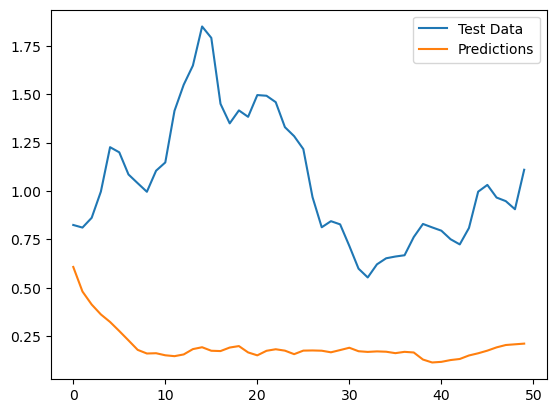

In [ ]:
# Plot the best model_name
test_predictions = []
first_eval_batch = x_minmax_train[-52:]
current_batch = first_eval_batch.reshape((1, 52, 1))
for i in range(len(y_minmax_test)):
    current_pred = model_name.predict(current_batch)[0]
    test_predictions.append(current_pred)
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)
true_predictions = scaler.inverse_transform(test_predictions)
test_predictions = pd.Series(true_predictions.reshape(50,))
y_uni_test = pd.Series(y_uni_test.reshape(50,))
plt.plot(y_uni_test, label='Test Data')
plt.plot(test_predictions, label='Predictions')
plt.legend()
plt.show()